# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import time
from sklearn.model_selection import train_test_split

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [2]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    df = pd.read_csv(f'{directory}/{file}')
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df

PermissionError: [Errno 13] Permission denied: 'dataset/.ipynb_checkpoints'

In [3]:
# Count null values
df.isna().sum()

NameError: name 'df' is not defined

In [4]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


NameError: name 'df' is not defined

In [5]:
# A simplfied billboard scraping function
def artist_billboard(artist_name):
    # convert artist name to - if spaces
    artist_name = artist_name.lower()
    artist_name = artist_name.replace(' ', '-')
    # if the name is in the saved dictionary (also saves time) 
    if artist_name in ARTIST_BB.keys():
        return ARTIST_BB[artist_name]
    else:
        base = 'https://www.billboard.com/artist/'
        url = base + artist_name
        page = requests.get(url)
        # if the page is not found, they are not a billboard artist 
        if page.reason == "Not Found":
            ARTIST_BB[artist_name] = 0
            return 0
        else:
            return 1 

# to apply: df['artistBB'] = df['Artist'].apply(artist_billboard)

#### Smaller Dataset for Policy Violation Regression 

In [19]:
# Define smaller data set for linear regression (for now)
slices = []
# slices are of size 100 due to Spotify constraints, currently 0 - 110 (ever growing) 
for i in range(209):
    slices.append(pd.read_csv(f'slices/slice{i}.csv'))
small = pd.concat(slices, axis=0)
small["Date"] = pd.to_datetime(small["Date"])
small["Day"] = pd.to_datetime(small["Date"]).dt.day_name()
small.fillna(0, inplace = True)
small

,Unnamed: 0.1,Unnamed: 0,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,...,loudness,mode,speechiness,acousticness,instruemtnalness,liveness,valence,tempo,duration_ms,Day
0,0,32428,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:00:43 AM,Darian Stavans,Ballad,Jazzy´Blue,...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Monday
1,1,32429,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:03:25 AM,Mack Fields,I Like to Yodel,"Cults Hits Novelty Classics, Vol. 1",...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Monday
2,2,32430,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:05:48 AM,Real Estate,Water Underground,Water Underground,...,-7.245,1.0,0.0314,0.0232,0.054200,0.1330,0.919,111.907,206547.0,Monday
3,3,32431,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:09:14 AM,My Morning Jacket,Feelin Sorry,Feelin Sorry,...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Monday
4,4,32432,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:12:02 AM,Joni Mitchell,A Case of You (feat. Marcus Mumford),A Case of You (feat. Marcus Mumford) (Live at ...,...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20895,53325,AM in the PM,169277,Ava P,2024-03-05,6:14:09 PM,Sidney Gish,"I'm Filled With Steak, and Cannot Dance",No Dogs Allowed,...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Tuesday
96,20896,53326,AM in the PM,169277,Ava P,2024-03-05,6:17:29 PM,Lunar Vacation,Blue Honey,Swell,...,-13.841,0.0,0.0555,0.0263,0.015700,0.3450,0.503,159.921,154960.0,Tuesday
97,20897,53327,AM in the PM,169277,Ava P,2024-03-05,6:19:57 PM,Buffalo Tom,Mineral,Let Me Come Over,...,0.000,0.0,0.0000,0.0000,0.000000,0.0000,0.000,0.000,0.0,Tuesday
98,20898,53328,AM in the PM,169277,Ava P,2024-03-05,6:25:00 PM,R.E.M.,Try Not To Breathe,Automatic For The People,...,-9.517,1.0,0.0374,0.0886,0.000943,0.0901,0.602,178.630,230573.0,Tuesday


#### Additional Collection: Filling Missing Genres and Spotify Audio Features

In [3]:
# global variable for valid genres in spinitron 
GENRES = small['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp
    
# just making this global for effeciency (no need to reaccess every time) 
sp = spotify_connect()

def get_genre_by_artist(artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    except TypeError:
        print(artist_name + "unable to search")
        return 'NA'
    # make sure that the result is for the artist we want
    try: 
        result_name = results['artists']['items'][0]['name']
    except IndexError:
        result_name = ''
        return 'NA'
    i = 0
    while (result_name != artist_name) & (i < 10) & (i < len(results)):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']
        for genre in genres:
            if genre in GENRES:
                return genre 
    return 'NA'

# to use: apply in sections of 100 from the original dataframe with 
small.loc[small["Genre"] == 0, "Genre"] = small.loc[small["Genre"].isna()].apply(get_genre_by_artist)

In [8]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

NameError: name 'df' is not defined

#### Data Wrangling and Visualization

In [9]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))


NameError: name 'df' is not defined

In [4]:
# Combine genres in the dataframe
# (Replace with higher count genre)
df = df.replace(
    {
        "R&B": "R&B/Soul",
        "Electro": "Electronic",
        "Metal": "Heavy Metal",
        "R&B/Soul/Funk": "R&B/Soul",
        "Reggaeton": "Reggae",
        "Rap/Hip Hop": "Hip Hop/Rap",
        "R & B": "R&B/Soul"
    }
)

# Visualize genre distribution, again
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

NameError: name 'df' is not defined

In [20]:
small = small.replace(
    {
        "R&B": "R&B/Soul",
        "Electro": "Electronic",
        "Metal": "Heavy Metal",
        "R&B/Soul/Funk": "R&B/Soul",
        "Reggaeton": "Reggae",
        "Rap/Hip Hop": "Hip Hop/Rap",
        "R & B": "R&B/Soul"
    }
)

In [ ]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [ ]:
# Temporary add (for work below), until the feature is properly created via scraping
df["Top100"] = np.random.randint(0, 1, df.shape[0])

# see artist_billboard function above! 

In [ ]:
def spins_to_dj(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Playlist Duration", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations
    dj_df["top_violations"] = spin_df[["DJ Name", "Top100"]].groupby(["DJ Name"]).sum().reset_index()["Top100"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["top_violations"]
    dj_df = dj_df.drop(columns=["new_violations", "top_violations"])

    return dj_df

djs_df = spins_to_dj(spin_df=df)
djs_df

In [21]:
def spins_to_dj_small(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    #duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    #dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')
    
     # audio features
    audio_df = spin_df[["DJ Name", "Date", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instruemtnalness", "liveness", "valence", "tempo", "duration_ms"]].groupby(["DJ Name"]).mean()
    dj_df = pd.merge(dj_df, audio_df, on=["DJ Name"], how='outer')

    #dj_df["new_percent"] = dj_df["New"] / dj_df["Total_Spins"]
    #dj_df["new_violations"] = (dj_df["new_percent"] < 0.25).astype(int)

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["Total_Spins"]
    dj_df["popular_violations"] = (dj_df["artist_violations"] > 0.2).astype(int)
    

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["popular_violations"] + dj_df["song_violations"]


    return dj_df

dj_df_small = spins_to_dj_small(small)
dj_df_small

C:\Users\16107\AppData\Local\Temp\ipykernel_39172\1598231001.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))


,DJ Name,Total_Spins,Avg_Start,Avg_Spins,0,Blues,Classical,Country,Electronic,Experimental,...,instruemtnalness,liveness,valence,tempo,duration_ms,artist_bb,artist_violations,popular_violations,song_violations,Violations
0,Adam Higgins,244,5.222222,27.111111,16.0,0.0,60.0,2.0,112.0,1.0,...,0.043239,0.017420,0.045080,14.454471,48138.000000,8,0.032787,0,0,1
1,Agent One,41,661.333333,13.666667,24.0,0.0,0.0,0.0,4.0,0.0,...,0.078300,0.052549,0.116824,29.435195,65282.268293,2,0.048780,0,0,3
2,Ava P,271,1082.500000,27.100000,120.0,0.0,0.0,1.0,7.0,0.0,...,0.082520,0.099200,0.272866,56.667384,104547.549815,38,0.140221,0,0,10
3,Babytooth,176,5.800000,35.200000,88.0,0.0,0.0,1.0,10.0,0.0,...,0.104001,0.057105,0.126226,38.554313,70817.920455,4,0.022727,0,0,3
4,Bix,161,842.142857,23.000000,70.0,1.0,0.0,23.0,4.0,0.0,...,0.066795,0.065084,0.189843,39.267733,71136.018634,24,0.149068,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,g wiz,131,662.111111,14.555556,54.0,4.0,0.0,1.0,8.0,0.0,...,0.111554,0.062601,0.205335,48.091252,86800.770992,2,0.015267,0,0,2
98,glumbus,76,1322.333333,25.333333,43.0,2.0,0.0,1.0,2.0,0.0,...,0.117832,0.061499,0.201292,43.074105,94685.960526,6,0.078947,0,0,3
99,ivy,203,1037.875000,25.375000,74.0,0.0,0.0,0.0,21.0,0.0,...,0.077534,0.069067,0.150650,47.108389,94172.970443,25,0.123153,0,0,3
100,lizard,14,603.000000,14.000000,7.0,0.0,0.0,0.0,0.0,0.0,...,0.124668,0.170064,0.234357,72.163929,113449.071429,0,0.000000,0,0,1


In [22]:
from scipy.stats import shapiro
from scipy.stats import lognorm

<Axes: xlabel='Violations', ylabel='Count'>

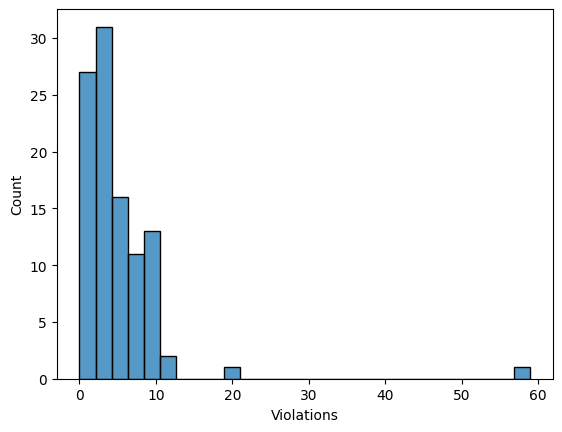

In [23]:
dj_df_small["Violations"] = dj_df_small["Violations"].astype(int)
sns.histplot(dj_df_small["Violations"])

             DJ Name  Total_Spins   Avg_Start  Avg_Spins       0  Blues  \
57           Emmanem          123  680.833333  10.250000    66.0    0.0   
60           JAH RED          601  889.947368  31.631579   167.0    0.0   
71  Program Director         5511   73.830508  93.406780  2563.0   18.0   

    Classical  Country  Electronic  Experimental  ...  instruemtnalness  \
57        0.0      2.0         6.0           0.0  ...          0.082349   
60        0.0      0.0         2.0           0.0  ...          0.016951   
71        5.0     58.0       422.0           0.0  ...          0.106581   

    liveness   valence      tempo   duration_ms  artist_bb  artist_violations  \
57  0.084225  0.222607  53.327846  98615.552846         12           0.097561   
60  0.041201  0.179097  30.352865  52681.356073         58           0.096506   
71  0.072364  0.185511  42.714324  87418.751951        294           0.053348   

    popular_violations  song_violations Violations  
57                  

<Axes: xlabel='Violations', ylabel='Count'>

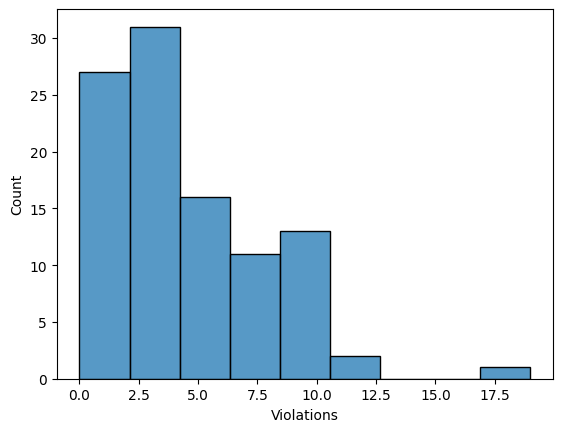

In [24]:
print(dj_df_small.loc[dj_df_small["Violations"] >= 12])
# removing program director because it is automation! 
dj_df_small = dj_df_small[dj_df_small["DJ Name"] != "Program Director"]
sns.histplot((dj_df_small["Violations"]))

C:\Users\16107\AppData\Local\Temp\ipykernel_39172\2174233406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj_df_small["Transformed Violations"] = None
C:\Users\16107\AppData\Local\Temp\ipykernel_39172\2174233406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj_df_small["Transformed Violations"] = np.log(dj_df_small["Violations"] + 1)


<Axes: xlabel='Transformed Violations', ylabel='Count'>

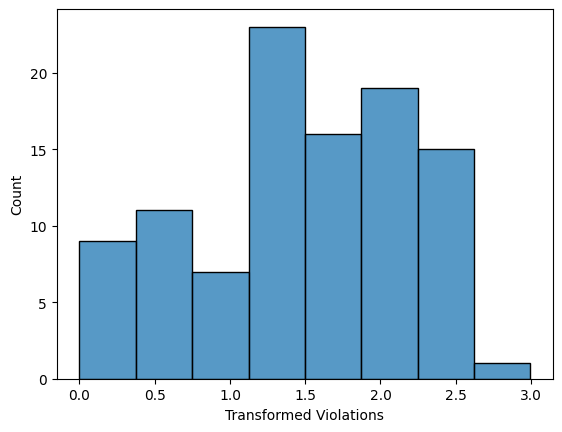

In [25]:
dj_df_small["Transformed Violations"] = None
dj_df_small["Transformed Violations"] = np.log(dj_df_small["Violations"] + 1)
sns.histplot(dj_df_small["Transformed Violations"])
#shapiro(np.log(dj_df_small["Violations"]))

In [60]:
def spins_to_shows(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in spin format
    """
    
    dj_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Date", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    dj_df = pd.merge(one_day_new_df, dj_df, on=["DJ Name", "Date"], how='outer')

    # time of day 
    dj_df["Time"] = spin_df[["Time", "DJ Name", "Date"]].groupby(["DJ Name", "Date"]).min().reset_index()["Time"]
    
    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Date", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title", "Date"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index=["DJ Name", "Date"], columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on=["DJ Name", "Date"], how='outer')

    # audio features
    audio_df = spin_df[["DJ Name", "Date", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instruemtnalness", "liveness", "valence", "tempo", "duration_ms"]].groupby(["DJ Name", "Date"]).mean()
    dj_df = pd.merge(dj_df, audio_df, on=["DJ Name", "Date"], how='outer')
    
    dj_df["new_percent"] = dj_df["New"] / dj_df["Total_Spins"]
    dj_df["new_violations"] = (dj_df["new_percent"] < 0.25).astype(int)

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["Total_Spins"]
    dj_df["popular_violations"] = (dj_df["artist_violations"] > 0.2).astype(int)
    

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["popular_violations"] + dj_df["song_violations"]

    
    return dj_df


show_df = spins_to_shows(small)
show_df.fillna(0, inplace= True)
show_df

,DJ Name,Date,New,Total_Spins,Time,0,Blues,Classical,Country,Electronic,...,valence,tempo,duration_ms,new_percent,new_violations,artist_bb,artist_violations,popular_violations,song_violations,Violations
0,Adam Higgins,2024-01-05,7,22,12:06:25 AM,1.0,0.0,5.0,0.0,14.0,...,0.055318,14.240864,45414.454545,0.318182,0,8.0,0.363636,1,0.0,1.0
1,Adam Higgins,2024-01-12,8,24,12:02:22 AM,1.0,0.0,8.0,0.0,8.0,...,0.048150,15.140833,62700.000000,0.333333,0,2.0,0.083333,0,0.0,0.0
2,Adam Higgins,2024-01-19,8,25,12:03:00 AM,0.0,0.0,8.0,0.0,17.0,...,0.001200,2.473560,5027.680000,0.320000,0,38.0,1.520000,1,0.0,1.0
3,Adam Higgins,2024-01-26,8,30,12:07:00 AM,4.0,0.0,8.0,0.0,18.0,...,0.037863,12.686500,53041.366667,0.266667,0,4.0,0.133333,0,0.0,0.0
4,Adam Higgins,2024-02-02,8,24,12:07:00 AM,1.0,0.0,8.0,0.0,3.0,...,0.097946,24.457917,68776.208333,0.333333,0,24.0,1.000000,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,otis cleveland,2024-01-30,0,40,8:00:33 PM,11.0,1.0,0.0,1.0,3.0,...,0.183845,42.370225,57160.150000,0.000000,1,0.0,0.000000,0,0.0,0.0
730,otis cleveland,2024-02-06,0,18,8:01:38 PM,4.0,0.0,0.0,1.0,0.0,...,0.149944,29.168389,55307.111111,0.000000,1,0.0,0.000000,0,0.0,0.0
731,otis cleveland,2024-02-13,0,33,10:03:59 PM,9.0,2.0,1.0,0.0,0.0,...,0.167273,25.250364,59831.909091,0.000000,1,0.0,0.000000,0,0.0,0.0
732,otis cleveland,2024-02-20,0,24,8:01:29 PM,11.0,0.0,0.0,0.0,0.0,...,0.191658,63.319542,160304.291667,0.000000,1,0.0,0.000000,0,0.0,0.0


<Axes: xlabel='Violations', ylabel='Count'>

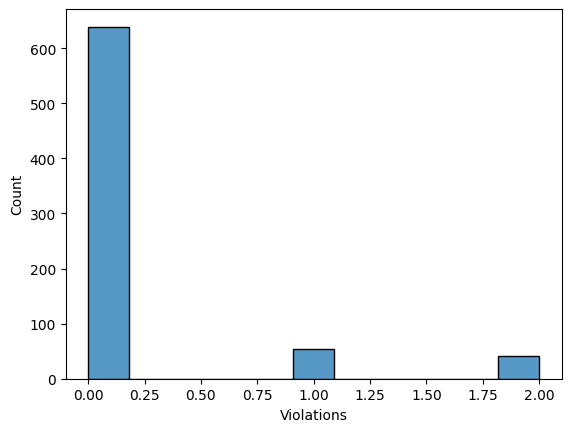

In [61]:
sns.histplot(show_df["Violations"])

## Data Modeling

### Policy Violation Linear Regression

In [17]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score 

#### Splitting and Preparing Data

In [30]:
dj_df_small.columns = dj_df_small.columns.astype(str)

train, test = train_test_split(dj_df_small, test_size = 0.2, train_size = 0.8)
#small_djs_X = dj_df_small.drop(["DJ Name",  "Date", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations"], axis=1)
#small_djs_Y = dj_df_small["Violations"]
small_djs_X_train = train.drop(["DJ Name", "Date",  "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "Transformed Violations"], axis=1)
small_djs_X_test = test.drop(["DJ Name", "Date", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "Transformed Violations"], axis=1)
small_djs_Y_train = train["Transformed Violations"]
small_djs_Y_test = test["Transformed Violations"]

#### Creating Model

In [31]:
regr = linear_model.LinearRegression()
regr.fit(small_djs_X_train, small_djs_Y_train)
small_djs_Y_pred = regr.predict(small_djs_X_test)
print("Coefficients: \n", regr.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, small_djs_Y_pred)}')
print(f'{regr.score(small_djs_X_test, small_djs_Y_test)}')
print(f'R2: {r2_score(small_djs_Y_test, small_djs_Y_pred)}')

Coefficients: 
 [ 5.37347998e+07  2.69706361e-04 -7.91481994e-02 -5.37347998e+07
 -5.37347999e+07 -5.37347998e+07 -5.37347998e+07 -5.37347998e+07
 -5.37348008e+07 -5.37347998e+07 -5.37347998e+07 -5.37347998e+07
 -5.37347998e+07 -5.37347998e+07 -5.37347998e+07 -5.37347998e+07
 -5.37347998e+07 -6.70103888e+00 -1.58604176e-01 -1.58604181e-01
 -4.18882450e-01 -3.59663844e+00  1.91126853e+01  1.65329976e+00
 -2.60416255e+00 -8.00540237e+00 -1.49839055e+00  1.37430609e-02
 -2.29479564e-06]
Mean Squared Error: 0.40759860941447446
-0.28559013984537907
R2: -0.28559013984537907


Text(0.5, 1.0, '')

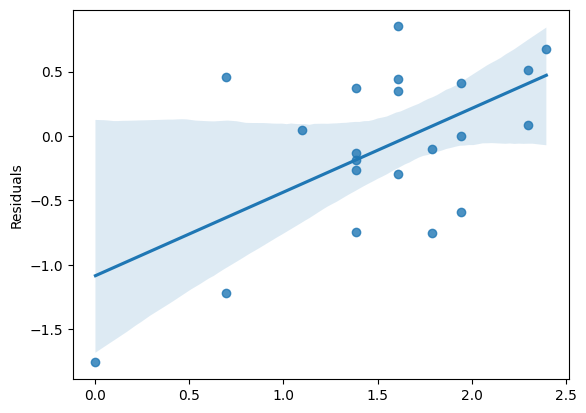

In [32]:
residuals = small_djs_Y_test - small_djs_Y_pred
ax = sns.regplot(x=small_djs_Y_test, y=residuals)
ax.set_xlabel('')
ax.set_ylabel('Residuals')
ax.set_title('')

Coefficients: 
 [ 1.61307185e+08  9.45394859e-05 -6.13590948e-02 -1.61307185e+08
 -1.61307185e+08 -1.61307185e+08 -1.61307185e+08 -1.61307185e+08
 -1.61307187e+08 -1.61307185e+08 -1.61307185e+08 -1.61307185e+08
 -1.61307185e+08 -1.61307185e+08 -1.61307185e+08 -1.61307185e+08
 -1.61307185e+08  5.27871935e+00  1.53612551e-03  1.53615136e-03
 -7.72936157e-02 -2.06590106e+00  1.07432052e+01  1.20013618e+00
 -2.97254124e+00  3.87216418e+00 -4.18579195e+00 -1.74714375e-02
 -5.98907166e-06]
Mean Squared Error: 1.6391808065788567
-2.939237057908988
R2: -2.939237057908988


Text(0.5, 1.0, '')

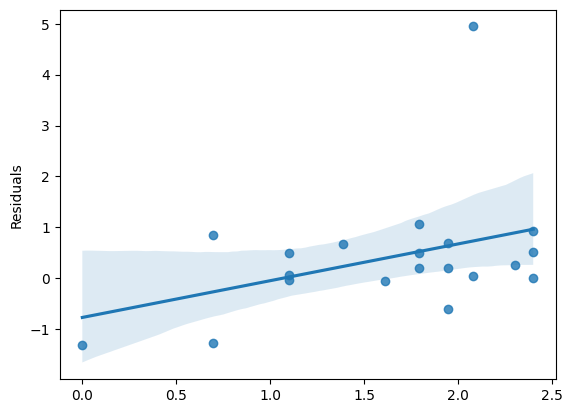

In [33]:
# remove another outlier (Jah_red)
dj_df_small = dj_df_small[dj_df_small["DJ Name"] != "JAH RED"]

train, test = train_test_split(dj_df_small, test_size = 0.2, train_size = 0.8)

small_djs_X_train = train.drop(["DJ Name", "Date",  "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "Transformed Violations"], axis=1)
small_djs_X_test = test.drop(["DJ Name", "Date", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "Transformed Violations"], axis=1)
small_djs_Y_train = train["Transformed Violations"]
small_djs_Y_test = test["Transformed Violations"]

regr = linear_model.LinearRegression()
regr.fit(small_djs_X_train, small_djs_Y_train)
small_djs_Y_pred = regr.predict(small_djs_X_test)

print("Coefficients: \n", regr.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, small_djs_Y_pred)}')
print(f'{regr.score(small_djs_X_test, small_djs_Y_test)}')
print(f'R2: {r2_score(small_djs_Y_test, small_djs_Y_pred)}')

residuals = small_djs_Y_test - small_djs_Y_pred
ax = sns.regplot(x=small_djs_Y_test, y=residuals)
ax.set_xlabel('')
ax.set_ylabel('Residuals')
ax.set_title('')

<Axes: xlabel='coef', ylabel='name'>

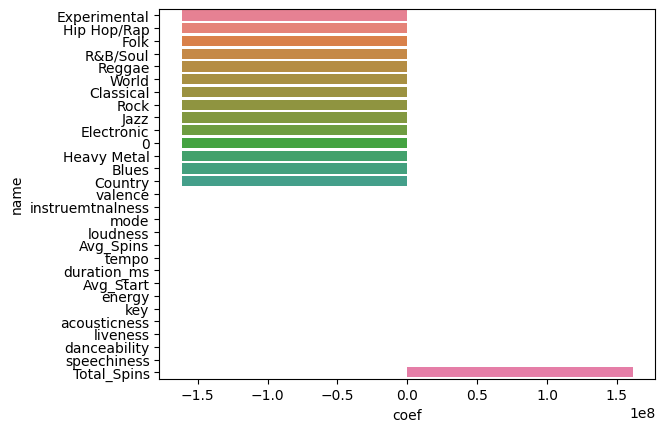

In [34]:
coeffs = (pd.DataFrame(zip(small_djs_X_train.columns, regr.coef_), columns=['name', 'coef'])).sort_values(by='coef', axis=0)
sns.barplot(x=coeffs['coef'], y=coeffs['name'], hue=coeffs['name'], data = coeffs)

#### Improving the Model

Coefficients: 
 [ 0.00000000e+00  1.67774575e-05 -1.27873841e-02  7.16860867e-03
  0.00000000e+00 -5.27664749e-03  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  8.16810311e-03 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -4.54649180e-06]
Mean Squared Error: 0.4228279287874572
-0.016129178375860587
R2: -2.939237057908988


<Axes: xlabel='coef', ylabel='name'>

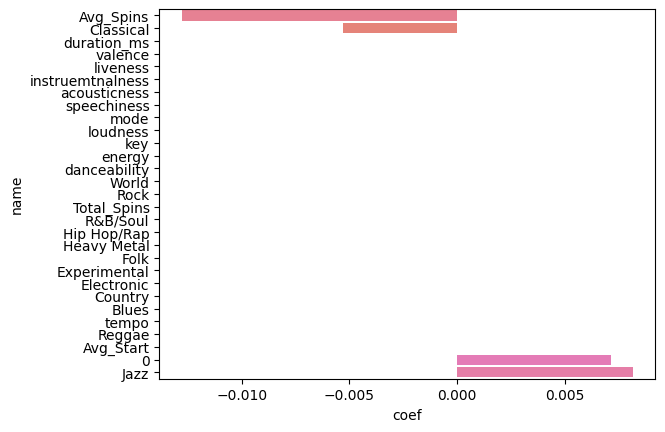

In [35]:
lasso_mod = linear_model.Lasso()
lasso_mod.fit(small_djs_X_train, small_djs_Y_train)
lasso_pred = lasso_mod.predict(small_djs_X_test)
print("Coefficients: \n", lasso_mod.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, lasso_pred)}')
print(f'{lasso_mod.score(small_djs_X_test, small_djs_Y_test)}')
print(f'R2: {r2_score(small_djs_Y_test, small_djs_Y_pred)}')

# add visualizations
coeffs = (pd.DataFrame(zip(small_djs_X_train.columns, lasso_mod.coef_), columns=['name', 'coef'])).sort_values(by='coef', axis=0)
sns.barplot(x=coeffs['coef'], y=coeffs['name'], hue=coeffs['name'], data = coeffs)

Coefficients: 
 [ 1.00309816e-02  1.38744106e-04 -5.06014366e-02 -1.49692995e-02
 -1.54748606e-02  1.92947500e-02  1.51197913e-01 -4.74541905e-03
 -2.35934560e-01 -1.53515562e-02 -1.49342392e-02 -3.03904049e-03
  3.35456264e-02  0.00000000e+00  0.00000000e+00 -2.96952327e-02
 -1.95610959e-02  1.88389866e-02 -2.75680159e-02  0.00000000e+00
 -6.23586115e-03 -8.51383357e-02  9.80889583e-02 -2.96005341e-02
 -2.96005341e-02 -1.87066434e-01 -1.10922431e-01  3.30371473e-02
  4.17673427e-02  2.22982748e-02 -1.04703326e-01 -6.72383275e-02
 -1.03517036e-02 -5.41658882e-06]
Mean Squared Error: 0.9646410366261875
-3.3488667330524846
R2: -3.6892934470578664


<Axes: xlabel='coef', ylabel='name'>

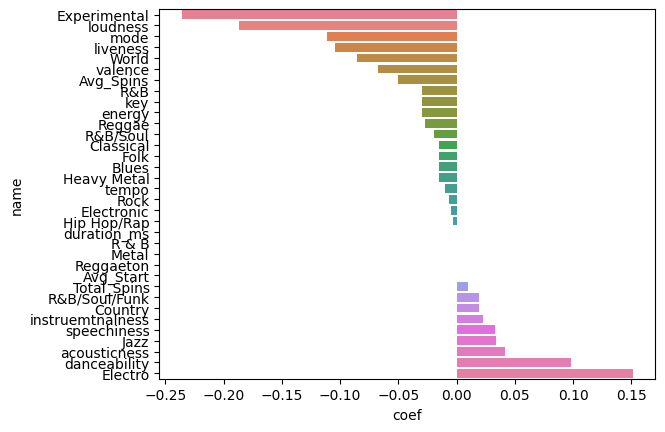

In [26]:
ridge_mod = linear_model.Ridge(alpha=1.0)
ridge_mod.fit(small_djs_X_train, small_djs_Y_train)
ridge_pred = ridge_mod.predict(small_djs_X_test)
print("Coefficients: \n", ridge_mod.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, ridge_pred)}')
print(f'{ridge_mod.score(small_djs_X_test, small_djs_Y_test)}')
print(f'R2: {r2_score(small_djs_Y_test, small_djs_Y_pred)}')
# add visualizations

coeffs = (pd.DataFrame(zip(small_djs_X_train.columns, ridge_mod.coef_), columns=['name', 'coef'])).sort_values(by='coef', axis=0)
sns.barplot(x=coeffs['coef'], y=coeffs['name'], hue=coeffs['name'], data = coeffs)

In [ ]:
# permutation importance 

### Logistic Regression of Violation

In [62]:
show_df['log_vol'] = None
show_df['log_vol'].loc[small_djs['Violations'] >= 1] = 1
show_df['log_vol'].loc[small_djs['Violations'] < 1] = 0
show_df['log_vol'].astype(int)
show_df

C:\Users\16107\AppData\Local\Temp\ipykernel_39172\2298383564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['log_vol'].loc[small_djs['Violations'] >= 1] = 1
C:\Users\16107\AppData\Local\Temp\ipykernel_39172\2298383564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['log_vol'].loc[small_djs['Violations'] < 1] = 0


,DJ Name,Date,New,Total_Spins,Time,0,Blues,Classical,Country,Electronic,...,tempo,duration_ms,new_percent,new_violations,artist_bb,artist_violations,popular_violations,song_violations,Violations,log_vol
0,Adam Higgins,2024-01-05,7,22,12:06:25 AM,1.0,0.0,5.0,0.0,14.0,...,14.240864,45414.454545,0.318182,0,8.0,0.363636,1,0.0,1.0,1
1,Adam Higgins,2024-01-12,8,24,12:02:22 AM,1.0,0.0,8.0,0.0,8.0,...,15.140833,62700.000000,0.333333,0,2.0,0.083333,0,0.0,0.0,0
2,Adam Higgins,2024-01-19,8,25,12:03:00 AM,0.0,0.0,8.0,0.0,17.0,...,2.473560,5027.680000,0.320000,0,38.0,1.520000,1,0.0,1.0,1
3,Adam Higgins,2024-01-26,8,30,12:07:00 AM,4.0,0.0,8.0,0.0,18.0,...,12.686500,53041.366667,0.266667,0,4.0,0.133333,0,0.0,0.0,0
4,Adam Higgins,2024-02-02,8,24,12:07:00 AM,1.0,0.0,8.0,0.0,3.0,...,24.457917,68776.208333,0.333333,0,24.0,1.000000,1,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,otis cleveland,2024-01-30,0,40,8:00:33 PM,11.0,1.0,0.0,1.0,3.0,...,42.370225,57160.150000,0.000000,1,0.0,0.000000,0,0.0,0.0,0
730,otis cleveland,2024-02-06,0,18,8:01:38 PM,4.0,0.0,0.0,1.0,0.0,...,29.168389,55307.111111,0.000000,1,0.0,0.000000,0,0.0,0.0,0
731,otis cleveland,2024-02-13,0,33,10:03:59 PM,9.0,2.0,1.0,0.0,0.0,...,25.250364,59831.909091,0.000000,1,0.0,0.000000,0,0.0,0.0,0
732,otis cleveland,2024-02-20,0,24,8:01:29 PM,11.0,0.0,0.0,0.0,0.0,...,63.319542,160304.291667,0.000000,1,0.0,0.000000,0,0.0,0.0,0


In [37]:
from sklearn import preprocessing 

In [63]:
print(sum(show_df['log_vol']))
violation_djs = show_df[["DJ Name"]][small_djs['log_vol'] == 1]["DJ Name"].unique()
print(violation_djs)

95
['Adam Higgins' 'Agent One' 'Ava P' 'Babytooth' 'Bix' 'Brad Barratt'
 'Chloe' 'Cordiform' 'Corey' 'Count Emily' 'DJ  Sweet T'
 'DJ Annie Banannie' 'DJ B']


In [64]:
train, test = train_test_split(show_df, test_size = 0.2, train_size = 0.8)

X_train = train.drop(["DJ Name", "Date", "Time", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations",  "log_vol"], axis=1)
X_test = test.drop(["DJ Name", "Date", "Time", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations",  "log_vol"], axis=1)

#scaler = preprocessing.StandardScaler().fit(X_train.values)
#X_scaled = scaler.transform(X_train.values)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

Y_train = train["log_vol"].astype(int)
Y_test = test["log_vol"].astype(int)

log_mod = linear_model.LogisticRegression(max_iter=1000)
log_mod.fit(X_train, Y_train)
Y_pred = log_mod.predict(X_test)
print(f'score: {log_mod.score(X_test, Y_test)}')

score: 0.9115646258503401


C:\Users\16107\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Decision Tree? 

In [40]:
from sklearn import tree
small_djs_Y_train = train["log_vol"]
#small_djs_X_train = small_djs_X_train.drop(["Avg_Start", "danceability", "energy", "key", "loudness", "speechiness", "mode", "acousticness", "instruemtnalness", "liveness", "valence", "tempo", "duration_ms"], axis=1)
violation_tree = tree.DecisionTreeClassifier()
violation_tree.fit(small_djs_X_train, small_djs_Y_train)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
from sklearn import ensemble
random_for = ensemble.RandomForestClassifier()
random_for.fit(small_djs_X_train, small_djs_Y_train)

### DJ Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

#### Dimensionality Reduction

In [ ]:
def determine_dimensionality(high_dim_df):
    """
    Plot the explained variance of the features with PCA
    to determine the dimensionality to be used.
    6 Components appears to be best, as it captures around
    80% of variability
    """

    high_dim_df = high_dim_df.drop(columns=["DJ Name"])

    # Apply standard scalar
    scalar = StandardScaler()
    x = scalar.fit_transform(X=high_dim_df)

    # PCA to find explained variances
    pca = PCA()
    pca.fit(x)

    # Visualize
    plt.plot(range(1, x.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker="o")
    print(f'Variance with 6 components: {pca.explained_variance_ratio_.cumsum()[5]}')

determine_dimensionality(djs_df)

In [ ]:
def dimension_reduction(high_dim_df: pd.DataFrame) -> np.ndarray:
    """
    Reduce dimensionality of the data to 2d for visualization and clustering
    """
    df_copy = high_dim_df
    #high_dim_df = high_dim_df[high_dim_df["DJ Name"] != "Program Director"]
    #high_dim_df = high_dim_df[high_dim_df["DJ Name"] != "JAH RED"]
    high_dim_df = high_dim_df.drop(columns=["DJ Name"])

    # Apply standard scalar
    scalar = StandardScaler()
    x = scalar.fit_transform(X=high_dim_df)

    # Apply PCA
    pca = PCA(n_components=6)
    x = pca.fit_transform(x)

    max_x_idx = np.argmax(x[:, 0])
    max_y_idx = np.argmax(x[:, 1])
    print(df_copy.iloc[max_x_idx, :])
    print(df_copy.iloc[max_y_idx, :])

    return x

def visualize(viz_data: np.ndarray):
    x = viz_data[:, 0]
    y = viz_data[:, 1]
    plt.scatter(x, y, s=2)

data = dimension_reduction(djs_df)
visualize(data)

#### Clustering Algorithm 1: DBSCAN

In [ ]:
def dbscan_silhouette(x: np.ndarray):
    # Find the silhouette scores for different eps
    scores = []
    eps_range = np.arange(0.5, 2, 0.1)
    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=2).fit(x)
        labels = db.labels_
        scores.append(silhouette_score(x, labels))

    # Visualize
    plt.plot(eps_range, scores, marker="o")

dbscan_silhouette(data)

In [ ]:
EPS = 1 # Chosen based on "bend" above

def dbscan_cluster(x: np.ndarray, eps=EPS):
    """
    Clustering using DBSCAN. DBSCAN is used because there are two obvious
    outliers. We hope that a density algorithm like DBSCAN can adjust for
    these outliers gracefully.
    """
    # Fit to clusters
    db = DBSCAN(eps=eps, min_samples=2)
    clusters = db.fit(x)
    labels = clusters.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Visualize
    def cluster_vis():
        """
        Function for visualizing the clusters
        Adapted from:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
        """

        unique_labels = set(labels)
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True

        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = labels == k
            xy = x[class_member_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
            )

    plt.figure(0)
    cluster_vis()
    plt.title(f"Number of clusters: {n_clusters_}")
    plt.show()

    # Zoom in visualization, ignoring outliers
    plt.figure(1)
    cluster_vis()
    plt.axis([-2, 7, -2, 7])
    plt.title(f"Number of clusters: {n_clusters_}")
    plt.show()

    # Return cluster counts
    cluster_num, counts = np.unique(labels, return_counts=True)
    return pd.Series(data=counts, index=cluster_num)

cluster_counts = dbscan_cluster(data)
cluster_counts

#### Clustering Algorithm 2: Agglomerative

In [ ]:
def agglom_silhouette(x: np.ndarray):
    # Find the silhouette scores for different eps
    scores = []
    n_range = range(2, 15)
    for n in n_range:
        agglom = AgglomerativeClustering(n_clusters=n).fit(x)
        labels = agglom.labels_
        scores.append(silhouette_score(x, labels))

    # Visualize
    plt.plot(n_range, scores, marker="o")

agglom_silhouette(data)

In [ ]:
N_CLUSTERS = 6 # Chosen based on silhouette analysis above

def agglom_cluster(x: np.ndarray, dj_names: np.ndarray, n_clusters: int = N_CLUSTERS):
    """
    Clustering using AgglomerativeClustering. An attempt to capture more
    data points than DBSCAN.
    """
    # Fit to clusters
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agglom.fit(x)
    labels = clusters.labels_

    # Visualize
    def cluster_vis():
        """
        Function for visualizing the clusters
        Adapted from:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
        """

        unique_labels = set(labels)

        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            class_member_mask = labels == k
            xy = x[class_member_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
                label=k
            )

    plt.figure(0)
    cluster_vis()
    plt.legend(loc="upper right")
    plt.title(f"Number of clusters: {n_clusters}")
    plt.show()

    # Zoom in visualization, ignoring outliers
    plt.figure(1)
    cluster_vis()
    plt.axis([-2, 7, -2, 7])
    plt.legend(loc="upper right")
    plt.title(f"Number of clusters: {n_clusters} (Zoomed)")
    plt.show()

    # Return cluster counts
    cluster_num, counts = np.unique(labels, return_counts=True)
    return labels, pd.Series(data=counts, index=cluster_num)


cluster_labels, cluster_counts = agglom_cluster(data, dj_names=djs_df["DJ Name"].unique())
cluster_counts

In [ ]:
def interpret_clusters(dj_df: pd.DataFrame, labels: np.ndarray):
    """
    Create a visual representation to interpret which archetypes
    the clusters represent.

    WORK IN PROGRESS!!
    """
    # Apply a StandardScalar to the data
    #dj_df = dj_df[dj_df["DJ Name"] != "Program Director"]
    #dj_df = dj_df[dj_df["DJ Name"] != "JAH RED"]
    dj_df = dj_df.drop(columns=["DJ Name"])
    scalar = StandardScaler()
    x = scalar.fit_transform(dj_df)
    clustered_df = pd.DataFrame(x, columns=dj_df.columns)

    # Average the features across each label
    clustered_df["label"] = labels
    clustered_df = clustered_df.groupby("label").mean()

    # Plot the features with labels
    clustered_df.plot.bar()

    return clustered_df

df1 = interpret_clusters(djs_df, cluster_labels)
df1

## Hypothesis Testing

### Policy Violation Linear Regression

In [ ]:
from scipy import stats

stats.mannwhitneyu

### DJ Clustering